# Performance analysis of a uniform linear array

We compare the MSE of MUSIC with the CRB for a uniform linear array (ULA).

In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import doatools.performance as perf
import matplotlib.pyplot as plt
%matplotlib inline

C:\Work\repos\pydoatools\doatools\optim\l1lsq.py:9: UserWarning: Cannot import cvxpy. Some sparse recovery based estimators will not be usable.
  warnings.warn('Cannot import cvxpy. Some sparse recovery based estimators will not be usable.')


In [16]:
wavelength = 1.0  # normalized
d0 = wavelength / 2

# Create a 12-element ULA.

locations = np.arange(np.power(12, 1 / 3))
x, y, z = np.meshgrid(locations, locations, locations)
locations = np.stack([x, y, z], axis=-1).reshape(-1, 3)
print(locations.shape)
ula = model.ArrayDesign(locations, name="UA")
# Place 8 sources uniformly within (-pi/3, pi/4)
sources = model.FarField2DSourcePlacement(
    np.stack([np.ones(1) * np.pi / 4,
              np.ones(1) * np.pi / 4], axis=-1)
)
# All sources share the same power.
power_source = 1  # Normalized
source_signal = model.ComplexStochasticSignal(sources.size, power_source)
# 200 snapshots.
n_snapshots = 200
# We use root-MUSIC.
grid = estimation.FarField2DSearchGrid()
estimator = estimation.MUSIC(ula, wavelength, grid)

(27, 3)


We vary the SNR from -20 dB to 20 dB. Here the SNR is defined as:
\begin{equation}
    \mathrm{SNR} = 10\log_{10}\frac{\min_i p_i}{\sigma^2_{\mathrm{n}}},
\end{equation}
where $p_i$ is the power of the $i$-th source, and $\sigma^2_{\mathrm{n}}$ is the noise power.

In [29]:
snrs = np.linspace(-20, 10, 20)
# 300 Monte Carlo runs for each SNR
n_repeats = 300

mses = np.zeros((len(snrs),))
crbs_sto = np.zeros((len(snrs),))
crbs_det = np.zeros((len(snrs),))
crbs_stouc = np.zeros((len(snrs),))

for i, snr in enumerate(snrs):
    power_noise = power_source / (10 ** (snr / 10))
    noise_signal = model.ComplexStochasticSignal(ula.size, power_noise)
    # The squared errors and the deterministic CRB varies
    # for each run. We need to compute the average.
    cur_mse = 0.0
    cur_crb_det = 0.0
    for r in range(n_repeats):
        # Stochastic signal model.
        A = ula.steering_matrix(sources, wavelength)
        S = source_signal.emit(n_snapshots)
        N = noise_signal.emit(n_snapshots)
        Y = A @ S + N
        Rs = (S @ S.conj().T) / n_snapshots
        Ry = (Y @ Y.conj().T) / n_snapshots


    B_sto, _ = perf.crb_sto_farfield_1d(ula, sources, wavelength, power_source,
                                        power_noise, n_snapshots)

    mses[i] = cur_mse / n_repeats
    crbs_sto[i] = np.mean(np.diag(B_sto))
    print('Completed SNR = {0:.2f} dB'.format(snr), crbs_sto[i])

Completed SNR = -20.00 dB 0.002482212639385974
Completed SNR = -18.42 dB 0.0013114586343507823
Completed SNR = -16.84 dB 0.0007115570625191428
Completed SNR = -15.26 dB 0.0003979336381847292
Completed SNR = -13.68 dB 0.00022988890687691724
Completed SNR = -12.11 dB 0.0001372223455076842
Completed SNR = -10.53 dB 8.44760930588275e-05
Completed SNR = -8.95 dB 5.344966322941608e-05
Completed SNR = -7.37 dB 3.4607237980212985e-05
Completed SNR = -5.79 dB 2.2826023638858355e-05
Completed SNR = -4.21 dB 1.5272742085802833e-05
Completed SNR = -2.63 dB 1.032958081866816e-05
Completed SNR = -1.05 dB 7.0419007075456014e-06
Completed SNR = 0.53 dB 4.828228677514311e-06
Completed SNR = 2.11 dB 3.3240483555950432e-06
Completed SNR = 3.68 dB 2.2951467520713037e-06
Completed SNR = 5.26 dB 1.5879780572528353e-06
Completed SNR = 6.84 dB 1.1002820202673758e-06
Completed SNR = 8.42 dB 7.631349874267259e-07
Completed SNR = 10.00 dB 5.296689962784246e-07


We plot the results below.

* The MSE should approach the stochastic CRBs in high SNR regions.
* The stochastic CRB should be tighter than the deterministic CRB.
* With the additional assumption of uncorrelated sources, we expect a even lower CRB.
* All three CRBs should converge together as the SNR approaches infinity.

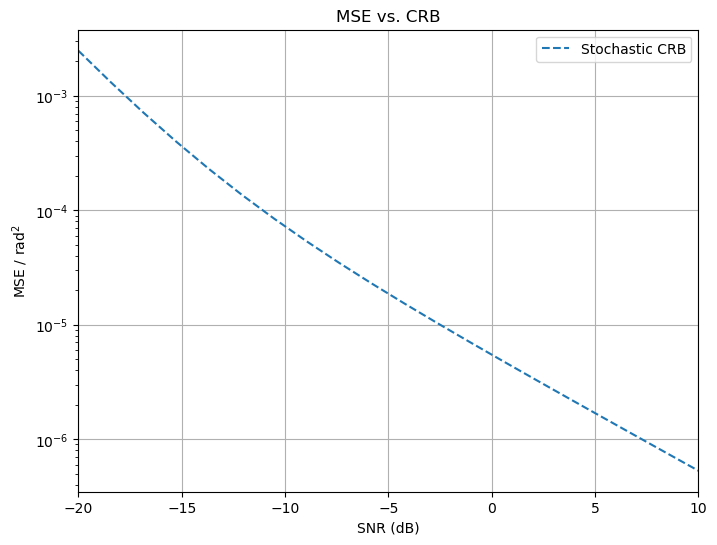

In [31]:
plt.figure(figsize=(8, 6))
plt.semilogy(

    snrs, crbs_sto, '--',

)
plt.xlabel('SNR (dB)')
plt.ylabel(r'MSE / $\mathrm{rad}^2$')
plt.grid(True)
plt.legend(['Stochastic CRB'])
plt.title('MSE vs. CRB')
plt.margins(x=0)
plt.show()